## Timeseries Data

Go over using Time Series MongoDB collections by scraping stock market data over the internet

##### Install Dependencies In Terminal (if you do not already have it)
```bash
pip install --user yfinance
pip install --user matplotlib
```

In [2]:
from pymongo import MongoClient

import pandas
import yfinance as yf
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

### Intro to yfinance

In [5]:
tickers = ["AMZN", "GOOGL"]
data = yf.download(tickers=tickers, period="1y", interval="1d")

[*********************100%***********************]  2 of 2 completed


In [6]:
print(type(data))
data[0:3]

<class 'pandas.core.frame.DataFrame'>


Price                       Adj Close                   Close              \
Ticker                           AMZN       GOOGL        AMZN       GOOGL   
Date                                                                        
2023-10-05 00:00:00+00:00  125.959999  134.736374  125.959999  135.070007   
2023-10-06 00:00:00+00:00  127.959999  137.240158  127.959999  137.580002   
2023-10-09 00:00:00+00:00  128.259995  138.078094  128.259995  138.419998   

Price                            High                     Low              \
Ticker                           AMZN       GOOGL        AMZN       GOOGL   
Date                                                                        
2023-10-05 00:00:00+00:00  126.730003  135.490005  124.330002  133.449997   
2023-10-06 00:00:00+00:00  128.449997  138.160004  124.129997  134.009995   
2023-10-09 00:00:00+00:00  128.789993  138.940002  124.760002  135.610001   

Price                            Open                Volume            
Ticker                           AMZN       GOOGL      AMZN     GOOGL  
Date                                                                   
2023-10-05 00:00:00+00:00  126.709999  135.070007  39660600  19832600  
2023-10-06 00:00:00+00:00  124.160004  134.009995  46795900  27583200  
2023-10-09 00:00:00+00:00  126.220001  136.940002  38773700  19278100

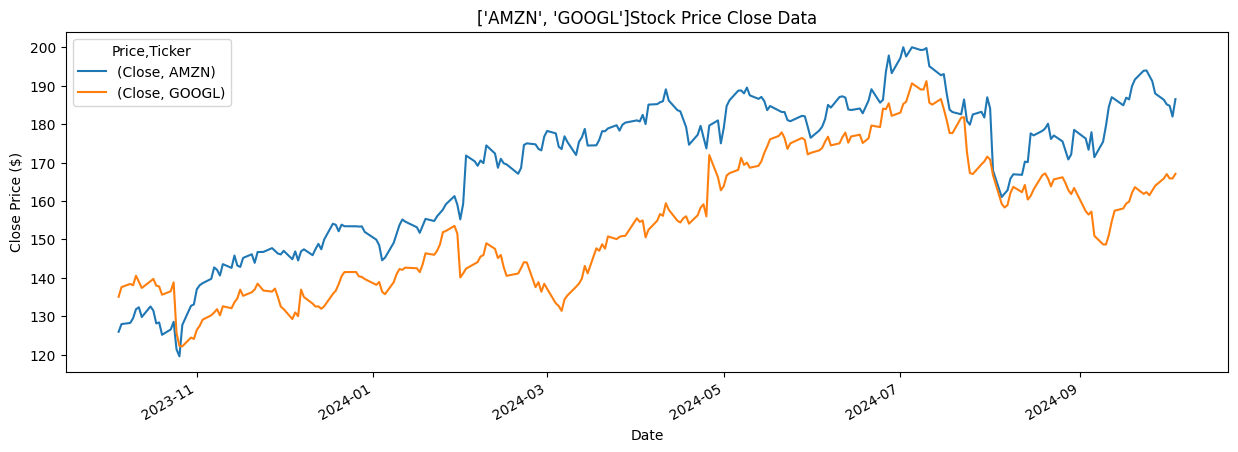

In [8]:
ax = data.plot(y=["Close"], figsize=(15,5), title=str(tickers) + "Stock Price Close Data")
ax.set_ylabel("Close Price ($)")
None

### Converting yfinance dataframe to dict format for insertion

##### Swap the columns so the ticker names are the highest level column

In [9]:
data.columns = data.columns.swaplevel(0,1)
data[0:3]

Ticker,AMZN,GOOGL,AMZN,GOOGL,AMZN,GOOGL,AMZN,GOOGL,AMZN,GOOGL,AMZN,GOOGL
Price,Adj Close,Adj Close,Close,Close,High,High,Low,Low,Open,Open,Volume,Volume
Date,,,,,,,,,,,,
2023-10-05 00:00:00+00:00,125.959999,134.736374,125.959999,135.070007,126.730003,135.490005,124.330002,133.449997,126.709999,135.070007,39660600,19832600
2023-10-06 00:00:00+00:00,127.959999,137.240158,127.959999,137.580002,128.449997,138.160004,124.129997,134.009995,124.160004,134.009995,46795900,27583200
2023-10-09 00:00:00+00:00,128.259995,138.078094,128.259995,138.419998,128.789993,138.940002,124.760002,135.610001,126.220001,136.940002,38773700,19278100


In [10]:
data["AMZN"][0:3]

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2023-10-05 00:00:00+00:00,125.959999,125.959999,126.730003,124.330002,126.709999,39660600
2023-10-06 00:00:00+00:00,127.959999,127.959999,128.449997,124.129997,124.160004,46795900
2023-10-09 00:00:00+00:00,128.259995,128.259995,128.789993,124.760002,126.220001,38773700


##### Create an attribute an each entry that has the name of the ticker

In [11]:
for ticker in tickers:
    data.loc[: , (ticker, "Ticker")] = ticker

In [12]:
data["GOOGL"][0:3]

Price,Adj Close,Close,High,Low,Open,Volume,Ticker
Date,,,,,,,
2023-10-05 00:00:00+00:00,134.736374,135.070007,135.490005,133.449997,135.070007,19832600,GOOGL
2023-10-06 00:00:00+00:00,137.240158,137.580002,138.160004,134.009995,134.009995,27583200,GOOGL
2023-10-09 00:00:00+00:00,138.078094,138.419998,138.940002,135.610001,136.940002,19278100,GOOGL


##### Set date index to a column 

In [13]:
data["AMZN"].reset_index(level=0)[0:3]

Price,Date,Adj Close,Close,High,Low,Open,Volume,Ticker
0,2023-10-05 00:00:00+00:00,125.959999,125.959999,126.730003,124.330002,126.709999,39660600,AMZN
1,2023-10-06 00:00:00+00:00,127.959999,127.959999,128.449997,124.129997,124.160004,46795900,AMZN
2,2023-10-09 00:00:00+00:00,128.259995,128.259995,128.789993,124.760002,126.220001,38773700,AMZN


##### Convert the dataframe to an array of dictionaries 

In [14]:
data["AMZN"].reset_index(level=0).to_dict('records')[0:2]

[{'Date': Timestamp('2023-10-05 00:00:00+0000', tz='UTC'),
  'Adj Close': 125.95999908447266,
  'Close': 125.95999908447266,
  'High': 126.7300033569336,
  'Low': 124.33000183105469,
  'Open': 126.70999908447266,
  'Volume': 39660600,
  'Ticker': 'AMZN'},
 {'Date': Timestamp('2023-10-06 00:00:00+0000', tz='UTC'),
  'Adj Close': 127.95999908447266,
  'Close': 127.95999908447266,
  'High': 128.4499969482422,
  'Low': 124.12999725341797,
  'Open': 124.16000366210938,
  'Volume': 46795900,
  'Ticker': 'AMZN'}]

### Connect To MongoDB instance

In [15]:
mongodb_uri = "mongodb://localhost:27017/"
db_name = "advanced_features"

In [16]:
client = MongoClient(mongodb_uri)
db = client[db_name]

### Creating  A Time-Series Collection

You could also use the compass app or mongoshell

In [17]:
db.create_collection("historical_stock_data", timeseries={
    "timeField": "Date",
    "metaField": "Ticker",
    "granularity": "hours"
}, expireAfterSeconds=60 * 60 * 24 * 365  # 1 year
)

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'advanced_features'), 'historical_stock_data')

### Inserting The Time-Series Stock Data

##### Download the data

In [19]:
tickers = ["AMZN", "META", "GOOGL", "MSFT", "UDMY"]
data = yf.download(tickers=tickers, period="2y", interval="1d")

[*********************100%***********************]  5 of 5 completed


##### Process dataframe into list of dictionaries

In [20]:
stock_data_to_insert = []

data.columns = data.columns.swaplevel(0,1)

for ticker in tickers:
    data.loc[: , (ticker, "Ticker")] = ticker
    stock_data_to_insert.extend(data[ticker].reset_index(level=0).to_dict('records'))

In [21]:
stock_data_to_insert[0:2]

[{'Date': Timestamp('2022-10-05 00:00:00+0000', tz='UTC'),
  'Adj Close': 120.94999694824219,
  'Close': 120.94999694824219,
  'High': 121.75,
  'Low': 117.69000244140625,
  'Open': 118.58000183105469,
  'Volume': 48217500,
  'Ticker': 'AMZN'},
 {'Date': Timestamp('2022-10-06 00:00:00+0000', tz='UTC'),
  'Adj Close': 120.30000305175781,
  'Close': 120.30000305175781,
  'High': 121.52999877929688,
  'Low': 119.5,
  'Open': 120.7699966430664,
  'Volume': 42253800,
  'Ticker': 'AMZN'}]

##### Call insert_many() on time series collection

In [22]:
db.historical_stock_data.insert_many(stock_data_to_insert)

InsertManyResult([ObjectId('67016b3f0457ddbb8fc311b6'), ObjectId('67016b3f0457ddbb8fc311b7'), ObjectId('67016b3f0457ddbb8fc311b8'), ObjectId('67016b3f0457ddbb8fc311b9'), ObjectId('67016b3f0457ddbb8fc311ba'), ObjectId('67016b3f0457ddbb8fc311bb'), ObjectId('67016b3f0457ddbb8fc311bc'), ObjectId('67016b3f0457ddbb8fc311bd'), ObjectId('67016b3f0457ddbb8fc311be'), ObjectId('67016b3f0457ddbb8fc311bf'), ObjectId('67016b3f0457ddbb8fc311c0'), ObjectId('67016b3f0457ddbb8fc311c1'), ObjectId('67016b3f0457ddbb8fc311c2'), ObjectId('67016b3f0457ddbb8fc311c3'), ObjectId('67016b3f0457ddbb8fc311c4'), ObjectId('67016b3f0457ddbb8fc311c5'), ObjectId('67016b3f0457ddbb8fc311c6'), ObjectId('67016b3f0457ddbb8fc311c7'), ObjectId('67016b3f0457ddbb8fc311c8'), ObjectId('67016b3f0457ddbb8fc311c9'), ObjectId('67016b3f0457ddbb8fc311ca'), ObjectId('67016b3f0457ddbb8fc311cb'), ObjectId('67016b3f0457ddbb8fc311cc'), ObjectId('67016b3f0457ddbb8fc311cd'), ObjectId('67016b3f0457ddbb8fc311ce'), ObjectId('67016b3f0457ddbb8fc311

### Retrieving Time-Series Data

In [23]:
gt_date = datetime.now() - relativedelta(months=6)
gt_date

datetime.datetime(2024, 4, 5, 17, 37, 51, 661914)

In [24]:
ts_cursor = db.historical_stock_data.find({"Ticker": "META", "Date": {"$gte": gt_date}})

fb_price_data = []

for entry in ts_cursor:
    fb_price_data.append(entry)

print(fb_price_data[0:2])

[{'Date': datetime.datetime(2024, 4, 8, 0, 0), 'Ticker': 'META', 'Open': 529.280029296875, 'Close': 519.25, 'High': 531.489990234375, 'Low': 518.8900146484375, 'Adj Close': 518.2406005859375, '_id': ObjectId('67016b3f0457ddbb8fc31526'), 'Volume': 13260600}, {'Date': datetime.datetime(2024, 4, 9, 0, 0), 'Ticker': 'META', 'Open': 522.22998046875, 'Close': 516.9000244140625, 'High': 525.8699951171875, 'Low': 506.739990234375, 'Adj Close': 515.8951416015625, '_id': ObjectId('67016b3f0457ddbb8fc31527'), 'Volume': 10881400}]


In [25]:
read_in_data = pandas.DataFrame(fb_price_data)
read_in_data = read_in_data.set_index("Date")
read_in_data = read_in_data.drop("_id", axis=1)

read_in_data

,Ticker,Open,Close,High,Low,Adj Close,Volume
Date,,,,,,,
2024-04-08,META,529.280029,519.250000,531.489990,518.890015,518.240601,13260600
2024-04-09,META,522.229980,516.900024,525.869995,506.739990,515.895142,10881400
2024-04-10,META,509.290009,519.830017,522.559998,505.799988,518.819458,11418500
2024-04-11,META,521.109985,523.159973,523.859985,517.289978,522.142944,10369500
2024-04-12,META,517.750000,511.899994,520.190002,509.329987,510.904846,11944900
...,...,...,...,...,...,...,...
2024-09-30,META,567.700012,572.440002,574.679993,564.799988,572.440002,12792300
2024-10-01,META,577.979980,576.469971,583.039978,570.099976,576.469971,15259300
2024-10-02,META,574.859985,572.809998,576.000000,569.340027,572.809998,6524700
